In [3]:
import pickle as pkl

with open('data4rec.pkl', 'rb') as f:
    data4rec = pkl.load(f)

In [4]:
games, win = data4rec['games'], data4rec['win']

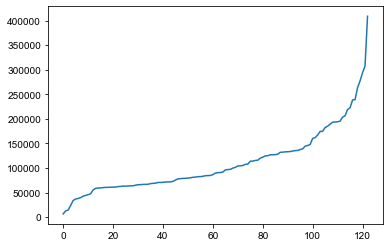

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.sort(np.sum(games.astype(np.uint32), axis=0)))

In [7]:
import numpy as np

# Deprecated
def get_preference_matrix(g, min_freq=0.02):
    m = g / np.expand_dims(np.sum(g, axis=1), 0).T
    for i, j in zip(*np.where(m < min_freq)):
        m[i][j] = 0
    for i in range(m.shape[0]):
        m[i, :] = (m[i] - np.min(m[i])) / (np.max(m[i]) - np.min(m[i]))
    return m

mp = get_preference_matrix(games)

In [8]:
import numpy as np

def get_preference_matrix2(g, ratio=[0.4, 0.7, 0.9]):
    m = np.zeros_like(g)
    pos = list(map(lambda x: int(g.shape[1] * x), ratio))
    for i, row in enumerate(g):
        sorted_idx = np.argsort(row)
        for j in sorted_idx[:pos[0]]:
            m[i][j] = 0
        for j in sorted_idx[pos[0]:pos[1]]:
            m[i][j] = 0.33
        for j in sorted_idx[pos[1]:pos[2]]:
            m[i][j] = 0.67
        for j in sorted_idx[pos[2]:]:
            m[i][j] = 1
    return m

mp = get_preference_matrix2(games)

In [9]:
from random import sample

def train_test_split(mp, test_ratio=0.3):
    train_mask, test_mask = np.zeros_like(mp), np.zeros_like(mp)
    for idx, r in enumerate(mp):
        item_pos = set(list(np.where(r > 0)[0]))
        test_pos = sample(item_pos, int(len(item_pos) * test_ratio))
        train_pos = item_pos.difference(test_pos)
        for pos in test_pos:
            test_mask[idx][pos] = 1
        for pos in train_pos:
            train_mask[idx][pos] = 1
    return train_mask * mp, test_mask * mp

train_mp, test_mp = train_test_split(mp)

In [10]:
testset = [(i, j, test_mp[i][j]) for i in range(mp.shape[0]) for j in range(mp.shape[1]) if test_mp[i][j] > 0]

In [11]:
def cos_sim(v1, v2):
    return np.sum(v1 * v2) / np.sqrt(np.sum(v1 * v1) * np.sum(v2 * v2))

def p_sim(v1, v2):
    return cos_sim(v1 - np.mean(v1), v2 - np.mean(v2))

In [12]:
def icf_pred(mp, uid_list, iid_list, top_item=2):
    isim = np.zeros((mp.shape[1], mp.shape[1]))
    for i in range(mp.shape[1]):
        isim[i][i] = 1
        for j in range(i + 1, mp.shape[1]):
            isim[i][j] = isim[j][i] = p_sim(mp[:, i], mp[:, j])
    
    res = []
    for uid, iid in zip(uid_list, iid_list):
        pos = list(np.where(mp[uid] > 0)[0])
        selected_items = map(lambda y: y[0], 
                             sorted(zip(pos, map(lambda i: isim[iid][i], pos)),
                                    key=lambda x: x[1])[-top_item:])
        res.append(
            np.mean(list(map(lambda i: mp[uid][i], selected_items)))
        )
        
    return res

def ucf_pred(mp, uid_list, iid_list, top_user=3):
    usim = np.zeros((mp.shape[0], mp.shape[0]))
    for i in range(mp.shape[0]):
        usim[i][i] = 1
        for j in range(i + 1, mp.shape[1]):
            usim[i][j] = usim[j][i] = cos_sim(mp[i, :], mp[j, :])
    
    res = []
    for uid, iid in zip(uid_list, iid_list):
        pos = list(np.where(mp[:, iid] > 0)[0])
        selected_items = map(lambda y: y[0], 
                             sorted(zip(pos, map(lambda i: usim[uid][i], pos)),
                                    key=lambda x: x[1])[-top_user:])
        res.append(
            np.mean(list(map(lambda i: mp[i][iid], selected_items)))
        )
        
    return res

select = lambda i, l: map(lambda x: int(x[i]), l) 
res = icf_pred(train_mp, select(0, testset), select(1, testset))

In [13]:
labels = np.array([0, 0.33, 0.67, 1])
l1 = []
eq = lambda x, y: np.abs(x - y) < 1e-5

for i in range(len(res)):
    l1.append(eq(testset[i][2], labels[np.argmin(np.abs(labels - res[i]))]))

In [14]:
np.mean(l1)

0.5135209409695504

In [432]:
testset

[(0, 7, 1.0),
 (0, 10, 1.0),
 (0, 18, 0.67),
 (0, 24, 0.33),
 (0, 32, 0.67),
 (0, 38, 0.33),
 (0, 39, 0.67),
 (0, 42, 0.67),
 (0, 46, 0.67),
 (0, 61, 0.67),
 (0, 65, 0.67),
 (0, 68, 0.67),
 (0, 71, 1.0),
 (0, 72, 1.0),
 (0, 73, 0.33),
 (0, 84, 0.33),
 (0, 89, 0.33),
 (0, 91, 1.0),
 (0, 95, 0.67),
 (0, 97, 0.33),
 (0, 107, 1.0),
 (0, 112, 0.67),
 (1, 3, 0.33),
 (1, 5, 0.33),
 (1, 10, 1.0),
 (1, 13, 0.33),
 (1, 16, 1.0),
 (1, 18, 0.67),
 (1, 21, 0.33),
 (1, 27, 0.33),
 (1, 41, 0.33),
 (1, 45, 0.33),
 (1, 46, 0.67),
 (1, 50, 0.67),
 (1, 51, 0.33),
 (1, 61, 0.67),
 (1, 62, 0.33),
 (1, 68, 0.33),
 (1, 70, 0.33),
 (1, 73, 0.33),
 (1, 82, 0.33),
 (1, 86, 0.33),
 (1, 93, 0.67),
 (1, 111, 0.33),
 (2, 0, 1.0),
 (2, 1, 0.33),
 (2, 6, 0.67),
 (2, 15, 0.33),
 (2, 18, 1.0),
 (2, 20, 0.67),
 (2, 23, 0.67),
 (2, 24, 0.33),
 (2, 32, 1.0),
 (2, 37, 0.67),
 (2, 39, 0.67),
 (2, 48, 0.33),
 (2, 51, 0.33),
 (2, 61, 0.33),
 (2, 63, 1.0),
 (2, 68, 0.67),
 (2, 85, 0.33),
 (2, 86, 0.33),
 (2, 89, 0.33),
 (2, 98

In [433]:
res

[0.78000003,
 0.89000005,
 0.33,
 0.33,
 0.6666667,
 0.33,
 0.78000003,
 0.44333336,
 0.5566667,
 0.44333336,
 0.5566667,
 0.5566667,
 0.5566667,
 0.89000005,
 0.33,
 0.44333336,
 0.33,
 0.67,
 0.44333336,
 0.44333336,
 0.5566667,
 0.6666667,
 0.5566667,
 0.89000005,
 1.0,
 0.44333336,
 0.89000005,
 0.89000005,
 0.33,
 0.33,
 0.33,
 0.44333336,
 0.78000003,
 0.89000005,
 0.55333334,
 0.5566667,
 0.33,
 0.89000005,
 0.78000003,
 0.33,
 0.33,
 0.33,
 0.78000003,
 0.89000005,
 0.78000003,
 0.33,
 0.44333336,
 0.33,
 0.78000003,
 0.6666667,
 0.89000005,
 0.44333336,
 1.0,
 1.0,
 0.67,
 0.5566667,
 0.33,
 0.44333336,
 0.55333334,
 0.5566667,
 0.44333336,
 0.44333336,
 0.5566667,
 0.44333336,
 0.44333336,
 0.55333334,
 0.44333336,
 0.6666667,
 0.44333336,
 0.78000003,
 0.6666667,
 1.0,
 1.0,
 0.44333336,
 0.44333336,
 0.44333336,
 0.6666667,
 0.89000005,
 0.44333336,
 0.33,
 0.33,
 0.55333334,
 1.0,
 0.33,
 0.33,
 1.0,
 0.44333336,
 0.77666664,
 0.77666664,
 0.55333334,
 0.33,
 0.44333336,
 